<div>
<img src="attachment:image.png" width="600" />
</div>

$Q(s, a|\theta^Q) \rightarrow critic$

$\mu(s|\theta^\mu) \rightarrow actor$

$Q^{'}(s, a|\theta^{Q'}) \rightarrow \text{target network}$

With $\tau << 1$, the target network (which is the critic in vanilla actor-critic) receives its weights slowly from the updated critic's weights, greatly improving the stability of learning (https://arxiv.org/abs/1509.02971)

"We found that having both a target $μ^{'}$ and $Q^{'}$ was required to have stable targets $y_i$
in order to consistently train the critic without divergence. This may slow learning, since
the target network delays the propagation of value estimations. However, in practice we found this
was greatly outweighed by the stability of learning." (https://arxiv.org/abs/1509.02971)

$\text{The policy gradient theorem establishes (for episodic problems)} \rightarrow \nabla J(\theta) \propto \sum_{s} \mu(s)\sum_{a} q_\pi(s,a)\nabla\pi(a|s,\theta)$

https://github-wiki-see.page/m/openai/gym/wiki/BipedalWalker-v2}
    
$\textbf{Description}$

Get a 2D biped walker to walk through rough terrain.

$\textbf{Environment : Observation}$
Type: Box(24)

$Num	Observation	Min	Max	Mean 
0	hull_angle	0	2*pi	0.5
1	hull_angularVelocity	-inf	+inf	-
2	vel_x	-1	+1	-
3	vel_y	-1	+1	-
4	hip_joint_1_angle	-inf	+inf	-
5	hip_joint_1_speed	-inf	+inf	-
6	knee_joint_1_angle	-inf	+inf	-
7	knee_joint_1_speed	-inf	+inf	-
8	leg_1_ground_contact_flag	0	1	-
9	hip_joint_2_angle	-inf	+inf	-
10	hip_joint_2_speed	-inf	+inf	-
11	knee_joint_2_angle	-inf	+inf	-
12	knee_joint_2_speed	-inf	+inf	-
13	leg_2_ground_contact_flag	0	1	-
14-23	10 lidar readings	-inf	+inf	-$

$\textbf{Actions}$
Type: Box(4) - Torque control(default) / Velocity control - Change inside /envs/box2d/bipedal_walker.py line 363

Num	Name	Min	Max

0	Hip_1 (Torque / Velocity)	-1	+1 

1	Knee_1 (Torque / Velocity)	-1	+1

2	Hip_2 (Torque / Velocity)	-1	+1

3	Knee_2 (Torque / Velocity)	-1	+1

$\textbf{Reward}$

Reward is given for moving forward, total 300+ points up to the far end. If the robot falls, it gets -100. Applying motor torque costs a small amount of points, more optimal agent will get better score. State consists of hull angle speed, angular velocity, horizontal speed, vertical speed, position of joints and joints angular speed, legs contact with ground, and 10 lidar rangefinder measurements. There's no coordinates in the state vector.

$\textbf{Starting State}$

Random position upright and mostly straight legs.

$\textbf{Episode Termination}$

The episode ends when the robot body touches ground or the robot reaches far right side of the environment.

In [2]:
# !pip install gym==0.18.0
# !pip3 install box2d-py
# !pip3 install gym[Box_2D]

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import gym
from collections import deque
from copy import deepcopy

In [3]:
class Actor(nn.Module):
    def __init__(self, input_size: int = 24, out_size: int = 4):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, out_size)
        self.bn1 = nn.BatchNorm1d(400)
        self.bn2 = nn.BatchNorm1d(300)
        self.out_act = nn.Tanh()
        self.act = nn.ReLU()

        self.init_weights()
        
    def forward(self, x : torch.Tensor):
        # print(torch.transpose(x, 0, 1).size())
        # print(self.fc1(x).size())
        x = self.act(self.bn1(self.fc1(x)))
        x =self.act(self.bn2(self.fc2(x)))
        return self.out_act(self.fc3(x))
    
    def init_weights(self):
        self.fc2.weight.data.uniform_(-3*1e-3, 3*1e-3)
        self.fc2.bias.data.uniform_(-3*1e-3, 3*1e-3)
        
        self.fc1.weight.data.uniform_(-3*1e-3, 3*1e-3)
        self.fc1.bias.data.uniform_(-3*1e-3, 3*1e-3)

In [4]:
class Critic(nn.Module):
    def __init__(self, input_size = 24 , action_space_sz = 4 ,out_size = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 400)
        self.fc2 = nn.Linear(400 + action_space_sz, 300)
        self.fc3 = nn.Linear(300, 1)
        self.bn1 = nn.BatchNorm1d(400)
        self.act = nn.ReLU()
        
        self.init_weights(input_size)
        
    def forward(self, s : torch.Tensor, a : torch.Tensor):
        x = self.act(self.bn1(self.fc1(s)))
        x = self.act(self.fc2(torch.cat((x, a), dim = 1)))
        return self.fc3(x)

    def init_weights(self):
        nn.init.uniform_(self.fc2.weight, -3*1e-3, 3*1e-3)
        nn.init.uniform_(self.fc2.bias, -3*1e-3, 3*1e-3)
        
        nn.init.uniform_(self.fc1.weight, -3*1e-3, 3*1e-3)
        nn.init.uniform_(self.fc1.bias, -3*1e-3, 3*1e-3)

In [14]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.4, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        # self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = deepcopy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

In [19]:
class Agent:
  def __init__(self, device,
               action_space_sz: int = 4,
               state_space_sz: int = 24, 
               tau = 0.001,
               discount_rate: float = 0.99,
               batch_size = 64):
    self.device = device
    self.action_space_sz = action_space_sz
    self.state_space_sz = state_space_sz
    self.tau = tau
    self.discount_rate = discount_rate

    self.r_buffer = deque(maxlen = 1000000)
    self.batch_size = 64
    self.learning_rate_actor = 0.0001
    self.learning_rate_critic = 0.001

    self.actor = Actor().to(device = self.device)
    self.critic = Critic().to(device = self.device)

    # target
    self.actor_ = Actor().to(device = self.device)
    self.critic_ = Critic().to(device = self.device)
    self.actor_.load_state_dict(deepcopy(self.actor.state_dict()))
    self.critic_.load_state_dict(deepcopy(self.critic_.state_dict()))

    # optimizer
    self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = self.learning_rate_actor)
    self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = self.learning_rate_critic, weight_decay=1e-2)

    self.env = gym.make("BipedalWalker-v3")
    self.noise = OUNoise((1, action_space_sz), seed)

  def sample_batch(self):
    indices = np.random.randint(0, len(self.r_buffer), size = self.batch_size)
    states, actions, rewards, next_states, dones = [[self.r_buffer[i][j] for i in indices] for j in range(5)]
    return states, actions, rewards, next_states, dones

  def update_target_networks(self, local_model, target_model, tau):
    """Soft update model parameters.
    """
    # # Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param = torch.clone(tau * param + (1.0 - tau)*t_param)

  def action_step(self, env, state):
    with torch.no_grad():
      self.actor.eval()
      # print(torch.tensor(state, dtype = torch.float)[None, :])
      a = self.actor(torch.tensor(state, dtype = torch.float)[None, :].to(device = self.device))
      a = a.to("cpu")
      action =  a + self.noise.sample()
      self.actor.train()
    action = action.squeeze().squeeze()
#     Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead
    observation, reward, done, info = env.step(action.detach().numpy())
    self.r_buffer.append((state, action.detach().numpy(), reward, observation, done))
    return observation, reward, done

  def train(self):
    states, actions, rewards, next_states, dones = self.sample_batch()
    states = torch.tensor(states, dtype = torch.float32).to(device = self.device)#[:, None]
    actions = torch.tensor(actions, dtype = torch.float32).to(device = self.device)#[:, None]
    next_states = torch.tensor(next_states, dtype = torch.float32).to(device = self.device)#[:, None]
    rewards = torch.tensor(rewards, dtype = torch.float32).to(device = self.device)#[:, None, None]
    
    self.optimizer_critic.zero_grad()
    # with torch.no_grad():
    actor_actions_ = self.actor_(next_states)
    dones = torch.tensor(dones, dtype = torch.int32).to(device = self.device)#[:, None, None]
    target = rewards + self.discount_rate * (1 - dones) * self.critic_(next_states, actor_actions_)
    loss = nn.MSELoss()
    l = loss(self.critic(states, actions), target)
    l.backward()
    self.optimizer_critic.step()
    
    self.optimizer_actor.zero_grad()
    actor_actions = self.actor(states)
    critic_values = - self.critic(states, actor_actions).sum()/self.batch_size
    critic_values.backward()
    self.optimizer_actor.step()
             
    self.update_target_networks(self.actor, self.actor_, self.tau)
    self.update_target_networks(self.critic, self.critic_, self.tau)

In [ ]:
# actor_.eval()
# print(torch.tensor(obs, dtype = torch.float32)[None, None, :].size())
# print(actor_(torch.tensor(obs, dtype = torch.float32)[None, None, :]).size())
# actor_.train()

In [ ]:
# states, actions, rewards, next_states, dones = sample_batch()
# torch.tensor(states[0], dtype = torch.float32).size()

In [ ]:
# s = torch.tensor(states[0], dtype = torch.float32)[None, :].to(device = device)
# a = torch.tensor(actions[0], dtype = torch.float32)[None, :].to(device = device)
# critic_.eval()
# critic_(s, a)

https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
seed = 42
np.random.seed(seed)
torch.seed()
agent = Agent(device)
rewards_l = []
win_len = 20
n_episodes = 1000
env = gym.make("BipedalWalker-v3")
for i in range(n_episodes):
    obs = env.reset()
    done = False
    rewards_sum = 0
    while(not done):
        obs, reward, done = agent.action_step(env, obs)
        rewards_sum += reward
    rewards_l.append(rewards_sum)
    avg_reward = sum(rewards_l[-win_len:])/min(win_len, len(rewards_l))

    agent.train()
    print(f"\r Episodes {i} Reward : {rewards_sum} Average reward for last {win_len} eps : {avg_reward}", end = "")

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 Episodes 999 Reward : -101.85343060855276 Average reward for last 20 eps : -102.52688263221732

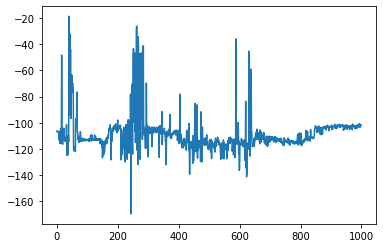

In [21]:
plt.plot(rewards_l)